In [2]:
import cv2
import torch
import tensorflow as tf
import numpy as np
import os
import keras
import sklearn

import matplotlib.pyplot as plt
import torch
import torchvision

from skimage import io, transform
import random

from hmmlearn import hmm

from skimage.feature import hog
from skimage import data, exposure

In [3]:
videos_dir = './../data/input/videos'
video_file = 'video1_switch_scene_{}.mkv'

### The First step

To segment video into different shots

In [3]:
def calc3colorsHist(image):
    
    chanels = cv2.split(image)
    hist = cv2.calcHist([chanels[0].astype(np.float32)], [0], None, [35], [0, 256])
    for chan in chanels[1:]:
            h = cv2.calcHist([chan.astype(np.float32)], [0], None, [35], [0, 256])
            hist = np.concatenate([hist, h], axis=-1)
            
    return np.max(hist, axis=-1)


def read_frame(vs, frame_size=(640, 480)):
    read_flag, frame = vs.read()
    frame = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), frame_size) if read_flag else None
    
    return read_flag, frame

N_COMPONENTS = 6
ITER = 100000
models_and_parts = [(hmm.GaussianHMM(n_components=N_COMPONENTS, n_iter=ITER,
                                    covariance_type="diag"), "1part"), (hmm.GaussianHMM(n_components=N_COMPONENTS, n_iter=ITER,
                                                                                       covariance_type="diag"), "2part")]

for model, part in models_and_parts:
    vs = cv2.VideoCapture(os.path.join(videos_dir, video_file.format(part)))

    read_flag, frame = read_frame(vs)
    hists = np.expand_dims(calc3colorsHist(frame), 0) if read_flag else 0
    while read_flag:
        read_flag, frame = read_frame(vs)
        if not read_flag:
            break
        hist = np.expand_dims(calc3colorsHist(frame), 0)
        hists = np.concatenate([hists, hist], axis=0)

    model.fit(hists)
    
models1 = models_and_parts[0][0]
models2 = models_and_parts[1][0]

### Checking the solution 

common_count = 0
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

def court_view(hist, estimator):
    score_1 = estimator[0].score(hist)
    score_2 = estimator[1].score(hist)
#     if random.random() > 0.99:
#         print("Score 1 {}; Score 2 {}".format(score_1, score_2))
    return score_1 > score_2

def con_mat_update(result, label):
    global true_positive, true_negative, false_positive, false_negative
    
    true_positive += result and label
    true_negative += (not result) and (not label) 
    false_negative += (not result) and label
    false_positive += result and (not label)

pos_labels_video_files = ['video3_nmm_checking_part3_pos.mkv',
                         'video3_nmm_checking_part5_pos.mkv']
neg_labels_video_files = ['video3_nmm_checking_part1_neg.mkv',
                         'video3_nmm_checking_part2_neg.mkv',
                         'video3_nmm_checking_part4_neg.mkv']
labels = [(pos_labels_video_files, True), (neg_labels_video_files, False)]

estimator = [models1, models2]

for files, label in labels:
    summ = 0
    num = 0
    for file in files:
        vs = cv2.VideoCapture(os.path.join(videos_dir, file))
        
        read_flag, frame = read_frame(vs)
        hist = calc3colorsHist(frame).reshape(1, -1)
        con_mat_update(court_view(hist, estimator), label)
        
        while read_flag:
            common_count += 1
            
            read_flag, frame = read_frame(vs)
            if not read_flag:
                break
            hist = calc3colorsHist(frame).reshape(1, -1)
            result = court_view(hist, estimator)
            con_mat_update(result, label)
            
            summ += result
            num += 1
    
    print("Average value for label {0} is {1}".format(label, np.round(summ/num, decimals = 3)))
        
print("Confusion matrix:")
print("True Positive (1 - 1) : {0} False Positive (1 - 0) : {1}".format(true_positive, false_positive))
print("False Negative (0 - 1) : {0} True Negative (0 - 0)  : {1}".format(false_negative, true_negative))
print("Common count {}".format(common_count))
print("Accuracy {}".format(np.round((true_positive + true_negative) / common_count, decimals=3)))
print("Recall {}".format(np.round(true_positive/(true_positive+false_negative), decimals=3)))
print("Precision {}".format(np.round(true_positive/(true_positive+false_positive), decimals=3)))

Average value for label True is 0.941
Average value for label False is 0.323
Confusion matrix:
True Positive (1 - 1) : 509 False Positive (1 - 0) : 144
False Negative (0 - 1) : 33 True Negative (0 - 0)  : 298
Common count 984
Accuracy 0.82
Recall 0.939
Precision 0.779


### The Second step

Court detection

In [7]:
images_dir = "./../data/input/images/video3_short_frames"
image_file = "frame_0820.jpg"

image = cv2.imread(os.path.join(images_dir, image_file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

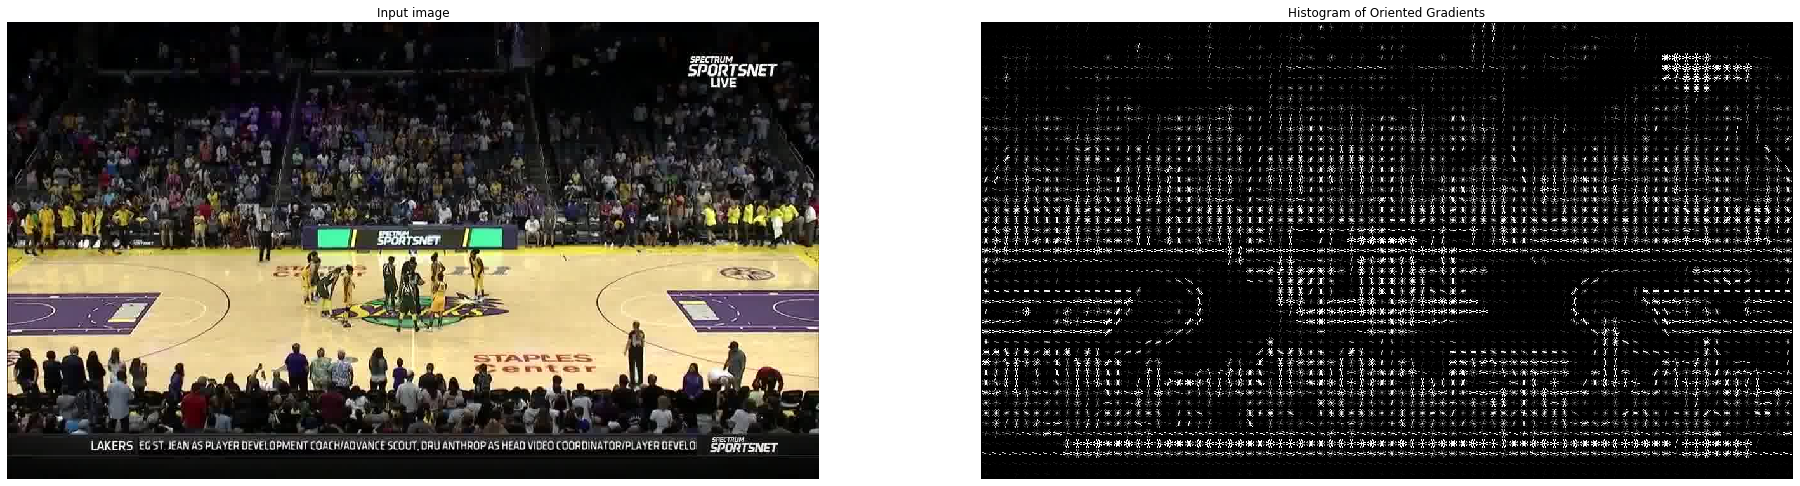

In [8]:
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [1]:
import numpy
numpy.version.version

'1.11.3'

In [ ]:
import tensorflow as tf

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import